# Trabajo ML

## Importamos las librerías necesarias

#### Librerías básicas para el tratamiento con datos y posteriores gráficos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Importamos funciones que iremos necesitando a lo largo del trabajo

In [2]:
from sklearn.utils import resample

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.preprocessing import LabelEncoder

# Librería necesaria para poder separar en conjuntos de training y testing
from sklearn.model_selection import train_test_split

#### Importamos también una librería que nos ayudará a codificar las variables categóricas

In [3]:
import category_encoders as ce

#### Importamos por otro lado la función tree necesaria para el posterior tree decision model

In [4]:
from sklearn import tree

#### Importamos las funciones necesarias para después poder hallar las medidas necesarias

In [5]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_score, accuracy_score, f1_score

#### Mostramos a continuación la creación de dos funciones propias que se han utilizado para encapsular código.

In [6]:
# Creamos la función evaluate_model que nos servirá más adelante para poder ver los valores de 
# diferentes medidas obtenidas por el modelo
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))    

In [7]:
# La función medidas nos permitirá tener un data frame en el que se mostrarán las medidas de precisión,
# F1 y accuracy de nuestras predicciones frente a nuestros valores de testing.
# Utilizaremos el algoritmo DecisionTreeClasifier en este caso con una profundidad máxima predeterminada de 50
# niveles pero este valor podrá ser modificado

def medidas(x_train_t, ytrain, x_test_t, ytest, profundidad = 51):
    Pred_1 = list()
    F1_1 = list()
    acc_1 = list()

    for i in range(1,profundidad):
        clf = tree.DecisionTreeClassifier(max_depth = i)
        clf = clf.fit(x_train_t, ytrain)
        predictions = clf.predict(x_test_t)
        pr = precision_score(ytest, predictions)
        Pred_1.append(pr)
        f1 = f1_score(ytest, predictions)
        F1_1.append(f1)
        ac = accuracy_score(ytest, predictions)
        acc_1.append(ac)
    data = {'F1': F1_1, "accuracy" :acc_1, 'precision':Pred_1}

    return pd.DataFrame(data, columns=["F1", "precision", 'accuracy'])

## Lectura del fichero csv

In [8]:
df_selected = pd.read_csv("../data/df_selected.csv")

In [9]:
# Echamos un vistazo rápido a la pinta que tiene el data frame
df_selected

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,application_type,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,disbursement_method,issue_month,issue_year,earliest_cr_year,credit_history
0,11575.0,11575.0,11575.0,36,7.35,359.26,A,A4,6,OWN,...,0,8.0,2.0,1.0,0.0,0,Jun,2017,1994,23
1,7200.0,7200.0,7200.0,36,24.85,285.70,E,E3,2,RENT,...,0,2.0,0.0,0.0,0.0,0,Jun,2017,2000,17
2,7500.0,7500.0,7500.0,36,7.35,232.79,A,A4,7,MORTGAGE,...,0,13.0,4.0,0.0,0.0,0,Jun,2017,2013,4
3,10000.0,10000.0,10000.0,60,16.02,243.29,C,C5,7,RENT,...,0,7.0,0.0,2.0,0.0,0,Jun,2017,2006,11
4,14000.0,14000.0,14000.0,36,16.02,492.34,C,C5,7,MORTGAGE,...,0,5.0,1.0,0.0,0.0,0,Jun,2017,2008,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442330,11575.0,11575.0,11575.0,36,15.59,404.61,D,D1,10,RENT,...,0,1.0,0.0,0.0,0.0,0,Jan,2015,1999,16
442331,12000.0,12000.0,12000.0,36,11.99,398.52,B,B5,1,MORTGAGE,...,0,11.0,1.0,0.0,0.0,0,Jan,2015,1995,20
442332,13000.0,13000.0,13000.0,60,15.99,316.07,D,D2,5,RENT,...,0,7.0,0.0,1.0,0.0,0,Jan,2015,2003,12
442333,12000.0,12000.0,12000.0,60,19.99,317.86,E,E3,1,RENT,...,0,6.0,0.0,0.0,0.0,0,Jan,2015,2003,12


#### Vamos ahora a mirar qué pinta tienen las variables del dataset. Para ello utilizaremos la función describe(). Añadiremos también un  include = "all" para obligar a que me incluya todas las columnas del dataset en el describe().

In [10]:
df_selected.describe(include = "all")

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,application_type,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,disbursement_method,issue_month,issue_year,earliest_cr_year,credit_history
count,442335.000000,442335.000000,442335.000000,442335.000000,442335.000000,442335.000000,442335,442335,442335.000000,442335,...,442335.000000,442335.000000,442335.000000,442335.000000,442335.000000,442335.000000,442335,442335.000000,442335.000000,442335.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,7,35,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,C,C1,NaN,MORTGAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,Oct,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,124885,26548,NaN,220364,...,NaN,NaN,NaN,NaN,NaN,NaN,56111,NaN,NaN,NaN
mean,14566.416856,14566.416856,14561.066882,42.140378,13.255884,439.935320,NaN,NaN,5.767755,NaN,...,0.002258,4.795908,1.776111,0.147868,0.056475,0.000020,NaN,2014.599414,1998.159006,16.440408
std,8500.018979,8500.018979,8496.756229,10.472109,4.471144,252.505972,NaN,NaN,3.722447,NaN,...,0.047470,3.143748,2.089641,0.397284,0.419215,0.004511,NaN,0.670304,7.464446,7.429709
min,1000.000000,1000.000000,900.000000,36.000000,5.320000,14.010000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2014.000000,1944.000000,3.000000
25%,8000.000000,8000.000000,8000.000000,36.000000,9.990000,256.900000,NaN,NaN,2.000000,NaN,...,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,NaN,2014.000000,1994.000000,11.000000
50%,12500.000000,12500.000000,12500.000000,36.000000,12.990000,378.760000,NaN,NaN,6.000000,NaN,...,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,NaN,2015.000000,2000.000000,15.000000
75%,20000.000000,20000.000000,20000.000000,60.000000,15.990000,579.720000,NaN,NaN,10.000000,NaN,...,0.000000,6.000000,3.000000,0.000000,0.000000,0.000000,NaN,2015.000000,2003.000000,20.000000


In [11]:
# filtro el df_selected en función de si la variable loan_status toma el valor 0 o 1
df_major = df_selected[df_selected.loan_status == 0]
df_minor = df_selected[df_selected.loan_status == 1]

In [12]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = 358436, random_state = 12345)
df_minor_upsmapled

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,application_type,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,disbursement_method,issue_month,issue_year,earliest_cr_year,credit_history
400464,28250.0,28250.0,28250.0,36,15.61,987.76,D,D1,2,MORTGAGE,...,0,9.0,3.0,0.0,0.0,0,Apr,2015,1994,21
366148,12175.0,12175.0,12175.0,60,25.80,363.09,G,G1,1,RENT,...,0,8.0,1.0,0.0,0.0,0,May,2015,1997,18
22099,2000.0,2000.0,2000.0,36,18.54,72.85,E,E1,2,MORTGAGE,...,0,20.0,2.0,1.0,0.0,0,Dec,2014,1988,26
396340,5000.0,5000.0,5000.0,36,14.65,172.48,C,C5,6,OWN,...,0,3.0,0.0,0.0,0.0,0,Mar,2015,1981,34
32729,12400.0,12400.0,12400.0,60,8.67,255.43,B,B1,1,RENT,...,0,1.0,0.0,0.0,0.0,0,Nov,2014,1983,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157970,21075.0,21075.0,20975.0,60,19.47,552.17,D,D5,1,OWN,...,0,4.0,6.0,0.0,0.0,0,May,2014,1994,20
243800,10000.0,10000.0,10000.0,36,12.05,332.39,C,C1,1,OWN,...,0,3.0,0.0,0.0,0.0,0,Dec,2015,2005,10
21700,5825.0,5825.0,5825.0,36,18.54,212.17,E,E1,10,OWN,...,0,4.0,0.0,0.0,2.0,0,Dec,2014,2003,11
236605,35000.0,35000.0,34750.0,36,14.48,1204.40,C,C5,1,MORTGAGE,...,0,5.0,0.0,0.0,1.0,0,Dec,2015,2000,15


In [13]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])
df_minor_upsmapled

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,application_type,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,disbursement_method,issue_month,issue_year,earliest_cr_year,credit_history
400464,28250.0,28250.0,28250.0,36,15.61,987.76,D,D1,2,MORTGAGE,...,0,9.0,3.0,0.0,0.0,0,Apr,2015,1994,21
366148,12175.0,12175.0,12175.0,60,25.80,363.09,G,G1,1,RENT,...,0,8.0,1.0,0.0,0.0,0,May,2015,1997,18
22099,2000.0,2000.0,2000.0,36,18.54,72.85,E,E1,2,MORTGAGE,...,0,20.0,2.0,1.0,0.0,0,Dec,2014,1988,26
396340,5000.0,5000.0,5000.0,36,14.65,172.48,C,C5,6,OWN,...,0,3.0,0.0,0.0,0.0,0,Mar,2015,1981,34
32729,12400.0,12400.0,12400.0,60,8.67,255.43,B,B1,1,RENT,...,0,1.0,0.0,0.0,0.0,0,Nov,2014,1983,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442326,13150.0,13150.0,13150.0,60,14.99,312.77,C,C5,8,MORTGAGE,...,0,0.0,3.0,0.0,0.0,0,Jan,2015,1994,21
442327,12000.0,12000.0,12000.0,36,9.49,384.34,B,B2,4,RENT,...,0,3.0,0.0,0.0,0.0,0,Jan,2015,2006,9
442328,4000.0,4000.0,4000.0,36,8.67,126.59,B,B1,10,MORTGAGE,...,0,8.0,1.0,1.0,0.0,0,Jan,2015,2002,13
442330,11575.0,11575.0,11575.0,36,15.59,404.61,D,D1,10,RENT,...,0,1.0,0.0,0.0,0.0,0,Jan,2015,1999,16


In [14]:
df_minor_upsmapled.loan_status.value_counts()

1    358436
0    345335
Name: loan_status, dtype: int64

In [15]:
df_minor_upsmapled.dtypes

loan_amnt               float64
funded_amnt             float64
funded_amnt_inv         float64
term                      int64
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_length                int64
home_ownership           object
annual_inc              float64
verification_status       int64
loan_status               int64
purpose                  object
addr_state               object
dti                     float64
delinq_2yrs             float64
fico_range_low          float64
fico_range_high         float64
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status       int64
application_type          int64
acc_open_past_24mths    float64
mort_acc                float64
pub_rec_bankruptcies    float64
tax_liens               float64
disbursement_method       int64
issue_mo

In [16]:
X = df_minor_upsmapled.drop("loan_status", axis = 1)
Y = df_minor_upsmapled.loan_status

In [17]:
Y = LabelEncoder().fit_transform(Y)

## Comenzamos el estudio con semilla 0

#### Separamos los conjuntos X e Y en training y testing mediante la función train_test_split(). Para ello vamos a utilizar la semilla 0 y un tamaño de testing del 25%

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=0)

#### Veamos ahora qué tipo de variables tenemos en xtrain. Nos interesa tener las variables en formato numérico para poder hacer el posterior análisis mediante un árbol de decisión.

In [19]:
xtrain.dtypes

loan_amnt               float64
funded_amnt             float64
funded_amnt_inv         float64
term                      int64
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_length                int64
home_ownership           object
annual_inc              float64
verification_status       int64
purpose                  object
addr_state               object
dti                     float64
delinq_2yrs             float64
fico_range_low          float64
fico_range_high         float64
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status       int64
application_type          int64
acc_open_past_24mths    float64
mort_acc                float64
pub_rec_bankruptcies    float64
tax_liens               float64
disbursement_method       int64
issue_month              object
issue_ye

In [20]:
xtrain.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,...,initial_list_status,application_type,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,disbursement_method,issue_year,earliest_cr_year,credit_history
count,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,5.278280e+05,527828.000000,527828.000000,...,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000
mean,14908.606213,14908.606213,14902.696015,43.586517,14.072943,445.751804,5.697413,7.324279e+04,0.267265,19.167385,...,0.560042,0.001870,5.018891,1.654880,0.151765,0.058009,0.000025,2014.608869,1998.380552,16.228317
std,8493.332604,8493.332604,8489.837090,11.158916,4.565485,249.899654,3.736866,6.983832e+04,0.442532,8.771095,...,0.496382,0.043202,3.227543,2.024245,0.403533,0.403209,0.004963,0.626757,7.442686,7.414240
min,1000.000000,1000.000000,900.000000,36.000000,5.320000,14.010000,0.000000,1.000000e+02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1944.000000,3.000000
25%,8225.000000,8225.000000,8225.000000,36.000000,10.990000,266.060000,2.000000,4.500000e+04,0.000000,12.760000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1995.000000,11.000000
50%,13175.000000,13175.000000,13175.000000,36.000000,13.670000,386.180000,6.000000,6.200000e+04,0.000000,18.740000,...,1.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,2015.000000,2000.000000,15.000000
75%,20000.000000,20000.000000,20000.000000,60.000000,16.990000,582.080000,10.000000,8.800000e+04,1.000000,25.300000,...,1.000000,0.000000,7.000000,3.000000,0.000000,0.000000,0.000000,2015.000000,2003.000000,20.000000
max,40000.000000,40000.000000,40000.000000,60.000000,30.990000,1587.230000,10.000000,8.900060e+06,1.000000,999.000000,...,1.000000,1.000000,53.000000,34.000000,12.000000,85.000000,1.000000,2017.000000,2014.000000,70.000000


#### Veamos qué columnas son de tipo object y cuales de tipo entero y float

In [21]:
num_xtrain = xtrain.select_dtypes(include=['int64', 'float64']).columns
cat_xtrain = xtrain.select_dtypes(include=['object']).columns

#### Dado que tenemos que modificar las columnas de tipo object, haremos uso del one hot encoding para convertirlas a numéricas. Este cambio se hace añadiendo columnas nuevas al data frame. Estas columnas tomarán únicamente los valores 1 o 0 dependiendo de si el individuo tiene una categoria determinada o no.

In [22]:
ohe = ce.OneHotEncoder(cols=cat_xtrain)
model = ohe.fit(xtrain)

In [23]:
x_train_t = model.transform(xtrain)
x_train_t

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade_1,grade_2,grade_3,grade_4,...,issue_month_6,issue_month_7,issue_month_8,issue_month_9,issue_month_10,issue_month_11,issue_month_12,issue_year,earliest_cr_year,credit_history
405387,13000.0,13000.0,13000.0,60,7.89,262.91,1,0,0,0,...,0,0,0,0,0,0,0,2015,2002,13
234295,10000.0,10000.0,10000.0,36,11.99,332.10,0,1,0,0,...,0,0,0,0,0,0,0,2015,1997,18
312077,25000.0,25000.0,25000.0,60,9.17,521.03,0,0,1,0,...,0,0,0,0,0,0,0,2015,1992,23
292927,35000.0,35000.0,35000.0,60,16.99,869.66,0,0,0,1,...,0,0,0,0,0,0,0,2015,1990,25
158822,35000.0,35000.0,35000.0,36,20.49,1309.49,0,0,0,0,...,0,0,0,0,0,0,0,2014,1998,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,12000.0,12000.0,11750.0,36,10.91,392.36,0,0,1,0,...,0,0,0,0,1,0,0,2017,2003,14
373782,18000.0,18000.0,18000.0,60,9.99,382.36,0,0,1,0,...,0,0,0,0,0,1,0,2015,2001,14
412304,12000.0,12000.0,12000.0,60,16.55,295.34,0,0,0,1,...,0,0,0,0,0,0,0,2015,2002,13
92961,25000.0,25000.0,25000.0,60,14.99,594.62,0,1,0,0,...,0,0,0,0,0,0,1,2014,1985,29


#### Ya estamos en condiciones para introducir el modelo de árbol de decisión. Para ello necesitamos la función tree que hemos importado al principio de la práctica

In [24]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train_t, ytrain)
clf

DecisionTreeClassifier()

#### Dibujamos el decision tree con 4 nodos de exploración máximos para que sea más fácil de visualizar

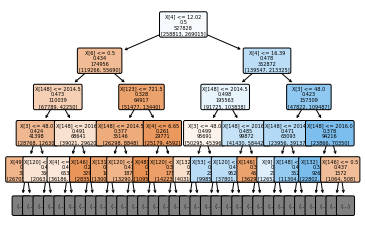

In [68]:
tree.plot_tree(clf, max_depth=4, filled=True, rounded=True, fontsize=5, label="none")
plt.show()

In [26]:
x_test_t = model.transform(xtest)
x_test_t

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade_1,grade_2,grade_3,grade_4,...,issue_month_6,issue_month_7,issue_month_8,issue_month_9,issue_month_10,issue_month_11,issue_month_12,issue_year,earliest_cr_year,credit_history
11255,28000.0,28000.0,28000.0,60,30.17,908.83,0,0,0,0,...,0,0,0,0,0,0,1,2017,2004,13
147808,10000.0,10000.0,10000.0,36,16.29,353.01,0,0,0,1,...,0,0,0,0,0,0,0,2014,2002,12
321285,10000.0,10000.0,10000.0,36,13.33,338.54,0,1,0,0,...,0,0,0,0,0,0,1,2015,2002,13
225872,29000.0,29000.0,29000.0,60,19.89,766.55,0,0,0,0,...,0,0,0,0,0,0,0,2015,2004,11
58860,35000.0,35000.0,35000.0,60,13.98,814.03,0,1,0,0,...,0,1,0,0,0,0,0,2014,1998,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81762,13775.0,13775.0,13775.0,60,22.15,381.63,0,0,0,0,...,0,0,0,0,0,0,0,2014,2009,5
122988,5000.0,5000.0,5000.0,36,11.67,165.29,0,0,1,0,...,0,0,0,0,0,0,0,2014,1999,15
40005,15000.0,15000.0,15000.0,60,17.14,373.92,0,0,0,1,...,0,0,1,0,0,0,0,2014,2006,8
188308,24000.0,24000.0,24000.0,60,22.45,669.01,0,0,0,0,...,0,0,0,1,0,0,0,2014,2001,13


## Comenzamos con las predicciones

In [1]:
predictions = clf.predict(x_train_t)
predictions

NameError: name 'clf' is not defined

In [28]:
predictions_proba = clf.predict_proba(x_train_t)
predictions_proba

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])


Hacemos la predicción de la cuarta fila del dataset


In [29]:
predict_4 = clf.predict(x_train_t)[4]
predict_4 == ytest[4]

True

In [30]:
print("Clasification report")
classification_report(ytest, predictions)

Clasification report


'              precision    recall  f1-score   support\n\n           0       0.95      0.77      0.85     86522\n           1       0.81      0.96      0.88     89421\n\n    accuracy                           0.87    175943\n   macro avg       0.88      0.86      0.86    175943\nweighted avg       0.88      0.87      0.86    175943\n'

In [31]:
DATAFRAME_medidas_1 = medidas(x_train_t, ytrain, x_test_t, ytest, profundidad=51)

In [32]:
round(DATAFRAME_medidas_1.pct_change(),3)

,F1,precision,accuracy
0,NaN,NaN,NaN
1,0.000,0.000,0.000
2,-0.070,0.080,0.016
3,0.044,0.007,0.025
4,0.002,0.004,0.003
5,0.017,-0.007,0.005
6,-0.007,0.015,0.004
7,0.013,-0.007,0.004
8,0.006,0.001,0.004
9,0.006,0.006,0.007


<AxesSubplot:>

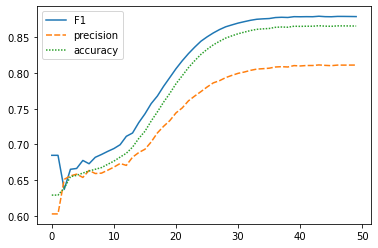

In [33]:
sns.lineplot(data = DATAFRAME_medidas_1)

### Curva ROC

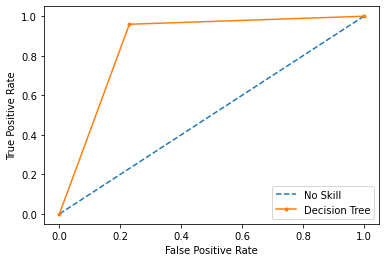

In [34]:
# keep probabilities for the positive outcome only
yhat = predictions_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Matriz de confusión

#### Mostremos además la matriz de confusión. 

##### Por un lado mostraremos esta matriz en valores absolutos y, después la mostraremos en valores relativos. De esta forma podremos comparar mejor los valores obtenidos

Text(0.5, 1.0, 'Normalized confusion matrix')

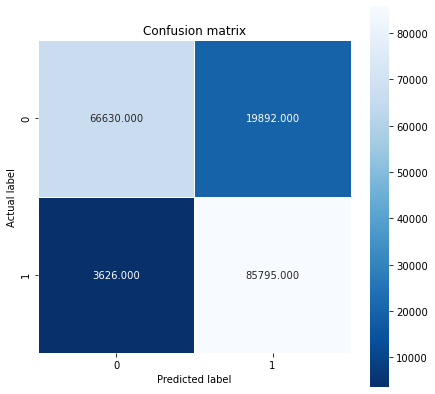

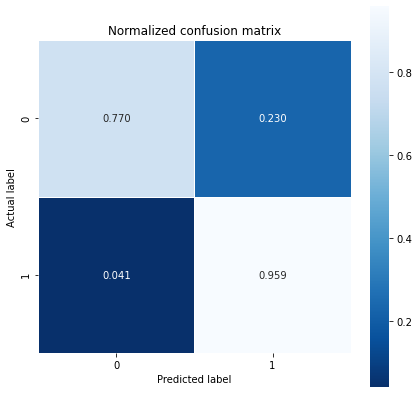

In [35]:
cm_gbt = confusion_matrix(ytest, predictions)
cm_gbt_norm = confusion_matrix(ytest, predictions, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

## Cambiamos de semilla a 12345.

#### Cambiamos la semilla de 0 a 12345. Realizaremos los mismos cálculos y compararemos los resultados obtenidos con ambas semillas

In [36]:
xtrain_2, xtest_2, ytrain_2, ytest_2 = train_test_split(X, Y, test_size=0.25, random_state=12345)

In [37]:
xtrain_2.dtypes

loan_amnt               float64
funded_amnt             float64
funded_amnt_inv         float64
term                      int64
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_length                int64
home_ownership           object
annual_inc              float64
verification_status       int64
purpose                  object
addr_state               object
dti                     float64
delinq_2yrs             float64
fico_range_low          float64
fico_range_high         float64
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status       int64
application_type          int64
acc_open_past_24mths    float64
mort_acc                float64
pub_rec_bankruptcies    float64
tax_liens               float64
disbursement_method       int64
issue_month              object
issue_ye

In [38]:
xtrain_2.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,...,initial_list_status,application_type,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,disbursement_method,issue_year,earliest_cr_year,credit_history
count,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,5.278280e+05,527828.000000,527828.000000,...,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000,527828.000000
mean,14910.330543,14910.330543,14904.402406,43.596975,14.073513,445.719309,5.700548,7.330144e+04,0.266935,19.160991,...,0.560067,0.001806,5.018430,1.658777,0.151763,0.058167,0.000027,2014.608317,1998.376947,16.231371
std,8491.198316,8491.198316,8487.703162,11.163046,4.562852,249.773826,3.737814,7.030243e+04,0.442359,8.779126,...,0.496379,0.042453,3.229736,2.029651,0.404727,0.411049,0.005150,0.626580,7.438839,7.409684
min,1000.000000,1000.000000,900.000000,36.000000,5.320000,30.120000,0.000000,1.000000e+02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1948.000000,3.000000
25%,8200.000000,8200.000000,8200.000000,36.000000,10.990000,265.910000,2.000000,4.500000e+04,0.000000,12.750000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1995.000000,11.000000
50%,13175.000000,13175.000000,13175.000000,36.000000,13.670000,386.430000,6.000000,6.200000e+04,0.000000,18.750000,...,1.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,2015.000000,2000.000000,15.000000
75%,20000.000000,20000.000000,20000.000000,60.000000,16.990000,582.080000,10.000000,8.800000e+04,1.000000,25.290000,...,1.000000,0.000000,7.000000,3.000000,0.000000,0.000000,0.000000,2015.000000,2003.000000,20.000000
max,40000.000000,40000.000000,40000.000000,60.000000,30.990000,1587.230000,10.000000,8.900060e+06,1.000000,999.000000,...,1.000000,1.000000,50.000000,47.000000,12.000000,85.000000,1.000000,2017.000000,2014.000000,66.000000


In [39]:
num_xtrain_2 = xtrain_2.select_dtypes(include=['int64', 'float64']).columns
cat_xtrain_2 = xtrain_2.select_dtypes(include=['object']).columns

##### Ahora pasamos las variables categóricas a one hot encoding

In [40]:
ohe_2 = ce.OneHotEncoder(cols=cat_xtrain_2)
model_2 = ohe_2.fit(xtrain_2)

In [41]:
x_train_t_2 = model_2.transform(xtrain_2)
x_train_t_2

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade_1,grade_2,grade_3,grade_4,...,issue_month_6,issue_month_7,issue_month_8,issue_month_9,issue_month_10,issue_month_11,issue_month_12,issue_year,earliest_cr_year,credit_history
57202,4200.0,4200.0,4200.0,36,12.49,140.49,1,0,0,0,...,0,0,0,0,0,0,0,2014,1985,29
227998,25900.0,25900.0,25900.0,36,18.49,942.73,0,1,0,0,...,0,0,0,0,0,0,0,2015,1995,20
158909,10000.0,10000.0,9950.0,36,12.99,336.90,1,0,0,0,...,0,0,0,0,0,0,0,2014,1994,20
252324,31375.0,31375.0,31375.0,60,20.99,848.63,0,1,0,0,...,0,0,0,0,0,0,0,2015,1999,16
173185,18975.0,18975.0,18975.0,36,21.99,724.57,0,1,0,0,...,0,0,0,0,0,0,0,2014,2001,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75015,6000.0,6000.0,6000.0,36,6.03,182.62,0,0,0,0,...,0,0,0,0,0,0,0,2014,1994,20
177805,12000.0,12000.0,11975.0,60,15.61,289.34,0,0,0,0,...,0,0,0,0,0,0,0,2014,2001,13
169768,15000.0,15000.0,15000.0,36,15.61,524.48,0,0,0,0,...,0,0,0,0,0,0,0,2014,2001,13
42978,14500.0,14500.0,14500.0,36,13.35,491.02,0,0,0,0,...,0,0,0,0,0,0,0,2014,1999,15


In [42]:
x_test_t_2 = model_2.transform(xtest_2)
x_test_t_2

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade_1,grade_2,grade_3,grade_4,...,issue_month_6,issue_month_7,issue_month_8,issue_month_9,issue_month_10,issue_month_11,issue_month_12,issue_year,earliest_cr_year,credit_history
297167,10000.0,10000.0,9975.0,36,16.99,356.48,0,0,1,0,...,0,0,0,0,0,0,1,2015,2010,5
160973,14400.0,14400.0,14400.0,60,14.16,336.26,0,0,0,0,...,0,0,0,0,0,0,0,2014,2000,14
14635,10000.0,10000.0,10000.0,36,10.42,324.65,1,0,0,0,...,0,0,0,0,1,0,0,2017,2007,10
205690,14800.0,14800.0,14800.0,36,13.53,502.46,1,0,0,0,...,0,0,0,1,0,0,0,2014,1996,18
283808,24500.0,24500.0,24500.0,60,13.99,569.95,0,0,0,0,...,1,0,0,0,0,0,0,2015,1992,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141797,10000.0,10000.0,10000.0,36,16.29,353.01,0,0,1,0,...,0,0,0,0,0,1,0,2014,2000,14
94369,6700.0,6700.0,6700.0,36,7.12,207.25,0,0,0,0,...,0,0,0,0,0,0,1,2014,2003,11
223762,30000.0,30000.0,30000.0,36,12.88,1009.09,0,0,0,0,...,0,0,0,0,0,0,0,2015,2002,13
224973,9000.0,9000.0,9000.0,36,14.85,311.33,0,0,0,0,...,0,0,0,0,0,0,0,2015,1986,29


In [43]:
clf_2 = tree.DecisionTreeClassifier()
clf_2 = clf_2.fit(x_train_t_2, ytrain_2)
clf_2

DecisionTreeClassifier()

#### Dibujamos el decision tree con 4 nodos de exploración máximos para que sea más fácil de visualizar

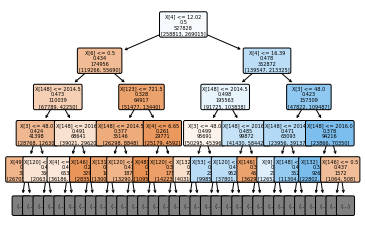

In [65]:
tree.plot_tree(clf, max_depth=4, filled=True, rounded=True, fontsize=5, label="none")
plt.show()

In [47]:
x_test_t_2 = model_2.transform(xtest_2)
x_test_t_2

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade_1,grade_2,grade_3,grade_4,...,issue_month_6,issue_month_7,issue_month_8,issue_month_9,issue_month_10,issue_month_11,issue_month_12,issue_year,earliest_cr_year,credit_history
297167,10000.0,10000.0,9975.0,36,16.99,356.48,0,0,1,0,...,0,0,0,0,0,0,1,2015,2010,5
160973,14400.0,14400.0,14400.0,60,14.16,336.26,0,0,0,0,...,0,0,0,0,0,0,0,2014,2000,14
14635,10000.0,10000.0,10000.0,36,10.42,324.65,1,0,0,0,...,0,0,0,0,1,0,0,2017,2007,10
205690,14800.0,14800.0,14800.0,36,13.53,502.46,1,0,0,0,...,0,0,0,1,0,0,0,2014,1996,18
283808,24500.0,24500.0,24500.0,60,13.99,569.95,0,0,0,0,...,1,0,0,0,0,0,0,2015,1992,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141797,10000.0,10000.0,10000.0,36,16.29,353.01,0,0,1,0,...,0,0,0,0,0,1,0,2014,2000,14
94369,6700.0,6700.0,6700.0,36,7.12,207.25,0,0,0,0,...,0,0,0,0,0,0,1,2014,2003,11
223762,30000.0,30000.0,30000.0,36,12.88,1009.09,0,0,0,0,...,0,0,0,0,0,0,0,2015,2002,13
224973,9000.0,9000.0,9000.0,36,14.85,311.33,0,0,0,0,...,0,0,0,0,0,0,0,2015,1986,29


## Comenzamos con las predicciones para nuestra nueva semilla

In [48]:
predictions_2 = clf_2.predict(x_test_t_2)
predictions_2

array([0, 0, 0, ..., 1, 1, 1])

In [49]:
predictions_proba_2 = clf_2.predict_proba(x_test_t_2)
predictions_proba_2

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])


#### Hacemos la predicción de la cuarta fila del dataset


In [50]:
predict_4_2 = clf_2.predict(x_test_t_2)[4]
predict_4_2 == ytest_2[4]

True

In [51]:
print("Clasification report")
classification_report(ytest_2, predictions_2)

Clasification report


'              precision    recall  f1-score   support\n\n           0       0.95      0.77      0.85     86028\n           1       0.81      0.96      0.88     89915\n\n    accuracy                           0.87    175943\n   macro avg       0.88      0.86      0.86    175943\nweighted avg       0.88      0.87      0.86    175943\n'

### Calculamos el data frame de las medidas

In [55]:
DATAFRAME_medidas_2 = medidas(x_train_t_2, x_test_t=x_test_t_2, ytrain=ytrain_2, ytest=ytest_2, profundidad=31)

In [56]:
round(DATAFRAME_medidas_2.pct_change(),3)

,F1,precision,accuracy
0,NaN,NaN,NaN
1,0.000,0.000,0.000
2,-0.071,0.080,0.014
3,0.044,0.007,0.025
4,-0.002,0.008,0.003
5,0.022,-0.012,0.005
6,-0.008,0.015,0.004
7,0.012,-0.002,0.006
8,0.011,-0.006,0.003
9,-0.007,0.018,0.005


<AxesSubplot:>

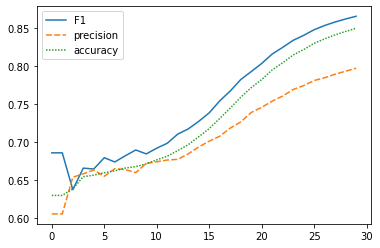

In [57]:
sns.lineplot(data = DATAFRAME_medidas_2)

### Curva ROC

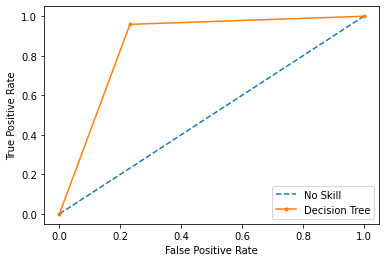

In [58]:
# keep probabilities for the positive outcome only
yhat_2 = predictions_proba_2[:, 1]
# calculate roc curves
fpr_2, tpr_2, thresholds_2 = roc_curve(ytest_2, yhat_2)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_2, tpr_2, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Matriz de confusión

#### Mostremos además la matriz de confusión. 

#### Por un lado mostraremos esta matriz en valores absolutos y, después la mostraremos en valores relativos. De esta forma podremos comparar mejor los valores obtenidos

Text(0.5, 1.0, 'Normalized confusion matrix')

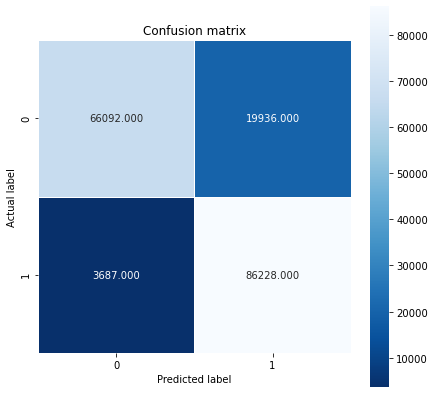

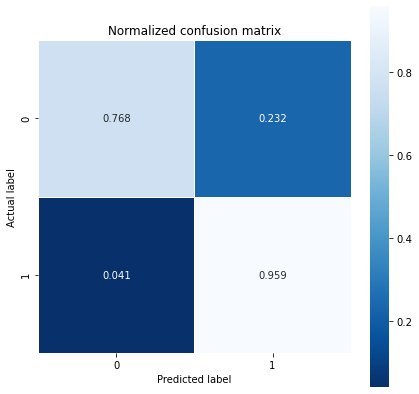

In [59]:
cm_gbt_2 = confusion_matrix(ytest_2, predictions_2)
cm_gbt_norm_2 = confusion_matrix(ytest_2, predictions_2, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_2, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_2, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

#### Creamos ahora un data frame en el que se muestra la medida F1 y los valores de accuracy y precision tanto para la semilla 0 como para la semilla 12345. También mostraremos las diferencias en porcentaje

In [60]:
p1 = precision_score(ytest, predictions)
p2 = precision_score(ytest_2, predictions_2)
f1 = f1_score(ytest, predictions)
f2 = f1_score(ytest_2, predictions_2)
ac1 = accuracy_score(ytest, predictions)
ac2 = accuracy_score(ytest_2, predictions_2)

dict_medidas = {'F1': [f1, f2, (abs(f1-f2)/max(f1,f2))*100], "accuracy" :[ac1, ac2, (abs(ac1-ac2)/max(ac1,ac2))*100], 
        'precision': [p1, p2, (abs(p1-p2)/max(p1,p2))*100]
       }
    
pd.DataFrame(dict_medidas, columns=["F1", "precision", 'accuracy'], index = ["semilla 0", "semilla 12345", 'diff %'])

,F1,precision,accuracy
semilla 0,0.879462,0.811784,0.866332
semilla 12345,0.879523,0.812215,0.865735
diff %,0.006983,0.053091,0.068886


#### Haciendo uso de la función evaluate_model creada al principio, podemos ver las diferentes medidas obtenidas para la semilla 0 y para la semilla 12345

In [61]:
evaluate_model(ytest, predictions, ypred_proba = predictions_proba)

ROC-AUC score of the model: 0.8647716982464342
Accuracy of the model: 0.8663317097014374

Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     86522
           1       0.81      0.96      0.88     89421

    accuracy                           0.87    175943
   macro avg       0.88      0.86      0.86    175943
weighted avg       0.88      0.87      0.86    175943


Confusion matrix: 
[[66630 19892]
 [ 3626 85795]]



In [62]:
evaluate_model(ytest_2, predictions_2, ypred_proba = predictions_proba_2)

ROC-AUC score of the model: 0.8636280511369132
Accuracy of the model: 0.8657349255156499

Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     86028
           1       0.81      0.96      0.88     89915

    accuracy                           0.87    175943
   macro avg       0.88      0.86      0.86    175943
weighted avg       0.88      0.87      0.86    175943


Confusion matrix: 
[[66092 19936]
 [ 3687 86228]]

